In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import HDBSCAN
import umap
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.io
import librosa as lr
import librosa.display as lrd
import ast
from scipy.signal import wiener

In [5]:
# ----- LOAD DATA -----

# load annotations
allannos = pd.read_csv('all_annotations_pairs1-25.csv')

# load UMAP coordinates
umaps = pd.read_csv('Scn2a-WT-HT-day1_latent_mean_umap_coords.csv',sep='\t')

In [3]:
# ----- SET UP COLORS -----

cols = [[0,1,0], # green for WT
       [1,0,1]]  # magenta for het

pal = sns.color_palette(cols) # seaborn palette

# set hue order
ho = ['WT','Het']

In [6]:
# ----- GIVE EACH ANNOTATION A LABEL BASED ON GENOTYPE -----

# tag number genotype lookup table
gtlookup = allannos.groupby(['Pairtag','GT']).size().reset_index().rename(columns={0:'count'})

# apply to umaps dataframes
newcol = umaps.Filename.apply(lambda x: x[2:-10]) # strip extra crap from filenames to get pair tags
umaps['Pairtag'] = newcol
umapsGT = umaps.join(gtlookup.set_index('Pairtag'), on='Pairtag') # merge with the genotype lookup so UMAP coords have GT info
umapsGT['duration'] = umapsGT.Offset-umapsGT.Onset

In [7]:
umapsGT.head()

,Filename,Onset,Offset,LMUx,LMUy,Pairtag,GT,count,duration
0,b'ScnVoc25_day1.wav',369.213027,369.235549,13.663003,6.745765,ScnVoc25,WT,5397,0.022522
1,b'ScnVoc25_day1.wav',369.403747,369.442893,10.588532,6.177857,ScnVoc25,WT,5397,0.039146
2,b'ScnVoc25_day1.wav',369.490259,369.552717,14.032599,2.291518,ScnVoc25,WT,5397,0.062458
3,b'ScnVoc25_day1.wav',371.271491,371.284541,1.453173,-1.399265,ScnVoc25,WT,5397,0.013050
4,b'ScnVoc25_day1.wav',371.316291,371.361341,14.795645,4.937538,ScnVoc25,WT,5397,0.045050


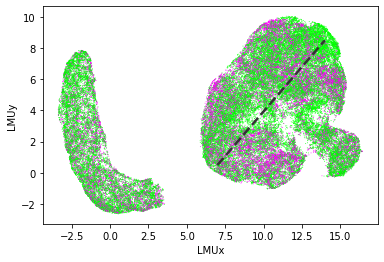

In [49]:
# ----- PLOT -----

sns.scatterplot(data=umapsGT,x='LMUx',y='LMUy',hue='GT',s=1,linewidth=0,alpha=0.75,palette=pal,legend=False)
# plt.plot([-2.25, -0.5],[7,-1.25],color='k', linewidth=2,)

gi = 0.2
plt.plot([7, 14],[0.5,8.5],'--',color=[gi,gi,gi], linewidth=2.5,)
r1 = [14,8.5] # WT
r2 = [12.5,6] # het
r3 = [11,5] # WT
r4 = [8.5,2] # het
r5 = [7.5,0.75] # WT
allr = [r1,r2,r3,r4,r5]

xs = []
ys = []
for co in allr:
    xs.append(co[0])
    ys.append(co[1])
# plt.scatter(xs,ys)

plt.savefig('Scn2a_WT-HT_day1_AVA-UMAP_wline.png',dpi=400.0)

In [22]:
# ----- FILTER INDIVIDUAL CALLS FOR PLOTTING EXAMPLES -----

# x,y coordinates for approximate location of example annotation
r1 = [14,8.5] # WT
r2 = [12.5,6] # het
r3 = [11,5] # WT
r4 = [8.5,2] # het
r5 = [7.5,0.75] # WT

allr = [r1,r2,r3,r4,r5]
rd = 0.1

for i,rx in enumerate(allr):
    
    xc = rx[0]
    yc = rx[1]
    
    f1 = np.logical_and(umapsGT.LMUx>xc-r,umapsGT.LMUx<xc+r)
    f2 = np.logical_and(umapsGT.LMUy>yc-r,umapsGT.LMUy<yc+r)

    f = np.logical_and(f1,f2)
    filtdf = umapsGT[f]
    
    fname = f'annoOpts_r{i+1}-{xc}-{yc}.csv'
    
    filtdf.to_csv(fname,index=False)

In [36]:
fname

'annoOpts_r5-7.5-0.75.csv'

In [9]:
# ----- GENERATE FILES OF SNIPS OF EXAMPLE SPECTROGRAMS FOR EACH SAMPLE POINT -----

# load up options dataframe
# loop over options
# grab file name
# load audio file
# display spectrogram corresponding to annotation boundaries

audpath = 'M:\\scn2a-paper-GWJSNH\\ScnVoc_acquisition'
specpath = os.path.join('figures','2025June','spectrogram_options')
# x,y coordinates for approximate location of example annotation
r1 = [14,8.5] # WT
r2 = [12.5,6] # het
r3 = [11,5] # WT
r4 = [8.5,2] # het
r5 = [7.5,0.75] # WT

allr = [r1,r2,r3,r4,r5]
rd = 0.1

user = allr[1:]

# spectrogram parameters
fs = 250000
NFFT = 512
noverl = 400
pad = 0.05
cmap = 'binary'
cmin = -60
cmax = 30
n_mfcc = 128 # 256
n_mels = n_mfcc
fmin = 20000
fmax = 80000

# parameters for mel spec
mel_nfft = 2048
mel_winlen = 900


for i,rx in enumerate(allr):
    
    xc = rx[0]
    yc = rx[1]
    
    f1 = np.logical_and(umapsGT.LMUx>xc-rd,umapsGT.LMUx<xc+rd)
    f2 = np.logical_and(umapsGT.LMUy>yc-rd,umapsGT.LMUy<yc+rd)

    f = np.logical_and(f1,f2)
    filtdf = umapsGT[f].reset_index()
    
    allsnips = []
    onsets = []
    
    for j,file in enumerate(np.unique(filtdf.Pairtag)):
        aname = f'{file}_day1.wav'
        
        fs, data = wavfile.read(os.path.join(audpath,aname))
        
        fdf = filtdf[filtdf.Pairtag==file].reset_index()
        
        for k,onset in enumerate(fdf.Onset):
        
            snip = data[int(np.floor(onset*fs)):int(np.floor(fdf.Offset[k]*fs))]
            
            f,ax = plt.subplots(figsize=(3, 4))
            
            # Calculate spectrogram of snippet
            melspec = lr.feature.melspectrogram(y=snip.astype(float),sr=fs,n_fft=mel_nfft,n_mels=n_mels,norm='slaney',\
                                            fmin=fmin,fmax=fmax,hop_length=mel_winlen) 
            
            img = lrd.specshow(melspec, x_axis='ms', y_axis='mel', sr=fs, fmin=fmin,fmax=fmax, ax=ax,cmap=cmap,
                          n_fft = mel_nfft,hop_length=mel_winlen)
            
            fname = f'spec_r{i+1}_{file}_{fdf.GT[k]}_{xc}-{yc}_{onset}s-{fdf.Offset[k]}s.png'
            
            plt.savefig(fname)
            
            plt.close()
            
#             allsnips.append(snip)
#             onsets.append(onset)
        
        data = None
        
#     d = {'onsets': onsets, 'snip': allsnips}
#     tempdf = pd.DataFrame(data=d)    
    
#     snipsdf = filtdf.join(tempdf.set_index('onsets'), on='Onset') # merge with the genotype lookup so UMAP coords have GT info
#     fname = f'annoOpts_r{i+1}-{xc}-{yc}.csv'    
#     snipsdf.to_csv(fname,index=False)

TypeError: float() argument must be a string or a real number, not 'ellipsis'

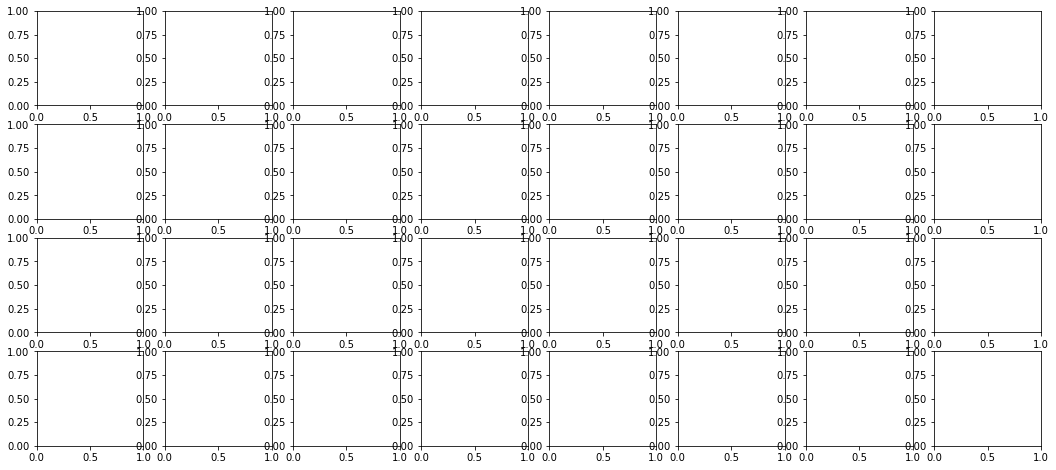

In [40]:
# load up file with snips
# make subplot structure
# loop over snips and plot spectrogram of each snip

# select best snip and export plot

# set up spectrogram parameters
# parameters for Welch PSD
fs = 250000
NFFT = 512
noverl = 400
pad = 0.05
cmap = 'jet'
cmin = -60
cmax = 30
n_mfcc = 128 # 256
n_mels = n_mfcc
fmin = 20000
fmax = 80000

# parameters for mel spec
mel_nfft = 2048
mel_winlen = 900

sniptab = pd.read_csv('annoOpts_r1-14-8.5.csv')
# sniptab['snipy'] = sniptab.snip.replace('  ', ',')
sniptab['snipy'] = sniptab.snip.apply(lambda x: x.replace('[ ','['))
sniptab['snipy'] = sniptab.snipy.apply(lambda x: x.replace('  ',','))
sniptab['snipy'] = sniptab.snipy.apply(lambda x: x.replace(' ',','))

sniptab['snipx'] = sniptab['snipy'].apply(lambda x: ast.literal_eval(x))
sniptab['snipp'] = sniptab['snipx'].apply(lambda x: np.asarray(x))

nrcols = 8
nrex = sniptab.shape[0]
nrrows = int(np.ceil(nrex/nrcols))

fig, axs = plt.subplots(nrrows, nrcols, figsize=(18, 2*nrrows))

for i,snip in enumerate(sniptab.snipp):
        
    # Calculate spectrogram of snippet
    melspec = lr.feature.melspectrogram(y=snip.astype(float),sr=fs,n_fft=mel_nfft,n_mels=n_mels,norm='slaney',\
                                            fmin=fmin,fmax=fmax,hop_length=mel_winlen) 

    # calculate subplot axis position
    row = i % nrows
    col = i // nrows
    ax = axs[row,col]
    img = lrd.specshow(usespec, x_axis='ms', y_axis='mel', sr=fs, fmin=fmin,fmax=fmax, ax=ax,cmap=cmap,
                          n_fft = mel_nfft,hop_length=mel_winlen)

In [38]:
sniptab

,index,Filename,Onset,Offset,LMUx,LMUy,Pairtag,GT,count,duration,snip,snipy,snipx
0,24246,b'ScnVoc15_day1.wav',1161.332243,1161.399821,14.027901,8.588337,ScnVoc15,WT,5537,0.067578,[395 426 469 ... 398 384 473],"[395,426,469,...,398,384,473]","[395, 426, 469, Ellipsis, 398, 384, 473]"
1,29502,b'ScnVoc21_day1.wav',2040.475059,2040.523421,13.916866,8.420370,ScnVoc21,het,1977,0.048362,[366 412 363 ... 264 289 212],"[366,412,363,...,264,289,212]","[366, 412, 363, Ellipsis, 264, 289, 212]"
2,41007,b'ScnVoc4_day1.wav',737.885747,737.985837,13.934430,8.572723,ScnVoc4,WT,8458,0.100090,[260 176 508 ... 758 682 674],"[260,176,508,...,758,682,674]","[260, 176, 508, Ellipsis, 758, 682, 674]"
3,41501,b'ScnVoc4_day1.wav',820.110915,820.194877,14.027019,8.521873,ScnVoc4,WT,8458,0.083962,[466 442 429 ... 672 539 450],"[466,442,429,...,672,539,450]","[466, 442, 429, Ellipsis, 672, 539, 450]"
4,41788,b'ScnVoc4_day1.wav',865.852579,865.915293,14.021305,8.537766,ScnVoc4,WT,8458,0.062714,[447 413 426 ... 476 442 406],"[447,413,426,...,476,442,406]","[447, 413, 426, Ellipsis, 476, 442, 406]"
5,41829,b'ScnVoc4_day1.wav',873.020003,873.119581,13.964773,8.517182,ScnVoc4,WT,8458,0.099578,[459 398 402 ... 516 434 413],"[459,398,402,...,516,434,413]","[459, 398, 402, Ellipsis, 516, 434, 413]"
6,41969,b'ScnVoc4_day1.wav',896.936323,897.014653,13.908475,8.410366,ScnVoc4,WT,8458,0.078330,[ 451 435 452 ... -279 -293 -460],"[451,435,452,...,-279,-293,-460]","[451, 435, 452, Ellipsis, -279, -293, -460]"
7,42175,b'ScnVoc4_day1.wav',928.402019,928.469597,13.927260,8.495916,ScnVoc4,WT,8458,0.067578,[580 502 409 ... 519 515 491],"[580,502,409,...,519,515,491]","[580, 502, 409, Ellipsis, 519, 515, 491]"
8,43193,b'ScnVoc4_day1.wav',1108.031731,1108.110573,14.025196,8.580267,ScnVoc4,WT,8458,0.078842,[442 477 536 ... 473 399 372],"[442,477,536,...,473,399,372]","[442, 477, 536, Ellipsis, 473, 399, 372]"
9,43287,b'ScnVoc4_day1.wav',1138.697699,1138.778333,13.953707,8.426520,ScnVoc4,WT,8458,0.080634,[518 480 448 ... 505 526 473],"[518,480,448,...,505,526,473]","[518, 480, 448, Ellipsis, 505, 526, 473]"


In [22]:
fs

250000

In [42]:
snipsdf.snip

0     [218, 243, 293, 327, 268, 240, 246, 272, 293, ...
1     [13, 10, 120, 156, 74, 28, 71, 144, 148, 64, 1...
2     [318, 317, 297, 268, 250, 265, 320, 325, 279, ...
3     [339, 349, 345, 374, 368, 342, 276, 271, 326, ...
4     [412, 356, 381, 398, 427, 435, 441, 480, 487, ...
5     [501, 441, 396, 399, 445, 448, 434, 445, 420, ...
6     [487, 504, 474, 430, 459, 490, 500, 463, 434, ...
7     [416, 398, 452, 482, 420, 348, 413, 505, 509, ...
8     [431, 364, 339, 403, 459, 406, 346, 364, 469, ...
9     [329, 314, 331, 318, 233, 244, 285, 335, 299, ...
10    [491, 508, 530, 551, 558, 558, 568, 530, 518, ...
11    [374, 464, 435, 353, 296, 325, 406, 466, 456, ...
12    [413, 470, 486, 451, 431, 444, 473, 519, 536, ...
13    [363, 328, 356, 406, 396, 368, 341, 347, 349, ...
14    [370, 350, 356, 406, 381, 373, 413, 477, 465, ...
15    [550, 520, 440, 399, 402, 406, 395, 388, 389, ...
16    [413, 419, 389, 427, 498, 558, 462, 353, 373, ...
17    [114, 108, 84, 74, 99, 95, 84, 65, 62, 107

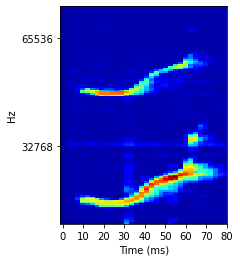

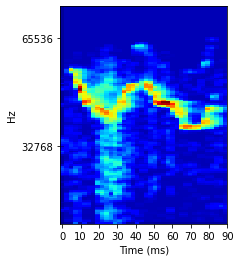

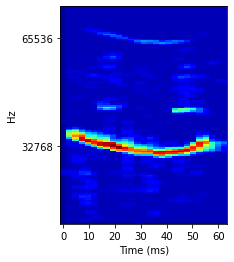

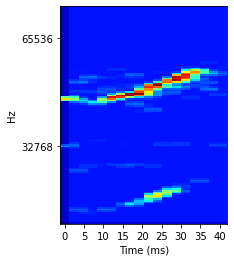

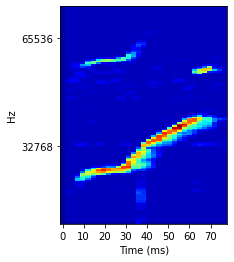

In [42]:
# specs to use

# parameters for Welch PSD
fs = 250000
NFFT = 4096*2 #4096 #2048 #1024 #512
noverl = 0.9*NFFT #800 #400
pad = 0.05
cmap = 'jet'
cmin = -60
cmax = 30
n_mfcc = 128 # 256
n_mels = n_mfcc
fmin = 20000
fmax = 80000

minval = 40
maxval = 255

# parameters for mel spec
mel_nfft = 1024 #2048
mel_winlen = 600

usespecs = ['spec_r1_ScnVoc4_WT_14-8.5_2242.888307s-2242.967405s',
    'spec_r3_ScnVoc17_WT_11-5_1602.557523s-1602.647629s',
    'spec_r5_ScnVoc22_WT_7.5-0.75_1723.532803s-1723.597309s',
    'spec_r2_ScnVoc21_het_12.5-6_1518.719571s-1518.760269s',
    'spec_r4_ScnVoc18_het_8.5-2_1087.291571s-1087.369389s']

# allsnips = []

pad = 15 # samples

# for spec in usespecs:
for i,snip in enumerate(allsnips):
    # pull out params
    px = usespecs[i].split('_')
    rgn = px[1]
#     aname = f'{px[2]}_day1.wav'
    GT = px[3]
    coords = px[4]
    coordspl = coords.split('-')
    xcoord = float(coordspl[0])
    ycoord = float(coordspl[1])
    
#     trng = px[5]
    
#     tsplt = trng.split('-')
#     st = float(tsplt[0].strip('s'))
#     et = float(tsplt[1].strip('s'))
    
    # load audio data
#     fs, data = wavfile.read(os.path.join(audpath,aname))
#     snip = data[int(np.floor(st*fs))-pad:int(np.floor(et*fs))+pad]

    f,ax = plt.subplots(figsize=(3, 4))
            
    # Calculate spectrogram of snippet
    melspec = lr.feature.melspectrogram(y=snip.astype(float),sr=fs,n_fft=mel_nfft,n_mels=n_mels,norm='slaney',\
                                            fmin=fmin,fmax=fmax,hop_length=mel_winlen) 
    
    usespec = lr.power_to_db(melspec)
    plotspec = replace_and_rescale(usespec,minval,maxval)
    wiener_kernel = (2, 2)
    plotspec = wiener(plotspec, wiener_kernel)
            
    img = lrd.specshow(plotspec, x_axis='ms', y_axis='mel', sr=fs, fmin=fmin,fmax=fmax, ax=ax,cmap=cmap,
                          n_fft = mel_nfft,hop_length=mel_winlen)
    
    fname = f'exSpec_{rgn}_{xcoord}-{ycoord}_{GT}.png'
    
    plt.savefig(os.path.join(specpath,fname))

    
#     allsnips.append(snip)

In [31]:
def replace_and_rescale(spec,minval,maxval):
    '''Find subthreshold values in a matrix and replace them with the threshold, then rescale to a provided max value.'''
    
    spec[spec<minval] = minval # replace subthreshold values
    spec *= (maxval/spec.max()) # rescale
    
    return spec

In [15]:
plt.get_fignums()

[]